In [1]:
from openai import OpenAI
import pandas as pd
df = pd.read_csv('verbs5.csv')
client = OpenAI()


def p2_translate_(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [
            {"role": "system", "content": 
                "نتا خبير فلهجة الدارجة المغربية وفالترجمة من الدارجة لنجليزية. " + 
                "غادي نعطيك واحد الفعل بالدارجة المغربية، والمهمة ديالك هي تترجمو دايما لفعل انجليزي واحد مجرد المصدر. " +
                "الترجمة خص يكون فيها غير جذر الفعل المترجم بلا تفسيرات."            
             },
            {"role": "user", "content": "شرب"},
            {"role": "assistant", "content": "drink"},
            {"role": "user", "content":  f'{verb}' }
        ],
        temperature=0
    )
    return completion.choices[0].message.content
def eng_p2_translate_(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [
            {"role": "system", "content": 
             "You are an expert in Language translation from Moroccan Darija dialect to English. " +
             "You will be provided with a verb in Moroccan Darija language, and your task is to ALWAYS translate it into ONE bare-infinitive English verb. " +
             "The translation must contain only the lemma of the translated verb with no explanations."},
            {"role": "user", "content": "شرب"},
            {"role": "assistant", "content": "drink"},
            {"role": "user", "content": f"{verb}"}
        ],
        temperature=0
    )
    return completion.choices[0].message.content
df.columns

Index(['darija_ar', 'eng', 'p1_transl', 'eng_p1_transl', 'p2_transl',
       'eng_p2_transl', 'p3_transl', 'eng_p3_transl'],
      dtype='object')

In [2]:
dataset = df.copy()
columns_to_delete = ['p1_transl', 'eng_p1_transl', 'p3_transl', 'eng_p3_transl']
dataset.drop(columns=columns_to_delete, inplace=True)
print(dataset.columns)
dataset.columns = ['darija_ar', 'eng', 'p1_transl', 'eng_p1_transl']
dataset.columns

Index(['darija_ar', 'eng', 'p2_transl', 'eng_p2_transl'], dtype='object')


Index(['darija_ar', 'eng', 'p1_transl', 'eng_p1_transl'], dtype='object')

In [3]:

dataset['p2_transl'] = dataset['darija_ar'].apply(p2_translate_)
dataset['eng_p2_transl'] = dataset['darija_ar'].apply(eng_p2_translate_)

In [4]:
dataset.to_csv('verbs6.csv', index=False)
print(dataset)

    darija_ar         eng   p1_transl eng_p1_transl   p2_transl eng_p2_transl
0         كلا         eat         eat           eat         eat           eat
1         شرب       drink       drink      to drink    drinking         drink
2         دخل       enter       enter         enter       enter         enter
3         خرج      go out      go out        go out      go out            go
4         فهم  understand  understand    understand  understand    understand
..        ...         ...         ...           ...         ...           ...
995      بلّغ      notify      inform         reach      inform         reach
996       طفا    turn off    turn off      turn off    turn off      turn off
997      ريّح    sit down       relax         smell       relax         smell
998        غش       cheat       cheat         cheat       cheat         cheat
999      قشّر        peel        peel          peel        peel          peel

[1000 rows x 6 columns]


In [5]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
import pandas as pd
dataset = pd.read_csv('verbs6.csv')

eng = dataset['eng']
eng = [verb.replace(" ", "_") for verb in eng]
p1_transl = dataset['p1_transl']
eng_p1_transl = dataset['eng_p1_transl']
p2_transl = dataset['p2_transl']
eng_p2_transl = dataset['eng_p2_transl']


p1_transl = [verb.replace(" ", "_") for verb in p1_transl]
eng_p1_transl = [verb.replace(" ", "_") for verb in eng_p1_transl]
p2_transl = [verb.replace(" ", "_") for verb in p2_transl]
eng_p2_transl = [verb.replace(" ", "_") for verb in eng_p2_transl]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score

def evaluate_pairs(transl,threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results



results_p1 = evaluate_pairs(p1_transl)
results_eng_p1 = evaluate_pairs(eng_p1_transl)
results_p2 = evaluate_pairs(p2_transl)
results_eng_p2 = evaluate_pairs(eng_p2_transl)


dataset['similarity_p1'] = [item[2] for item in results_p1]
dataset['similarity_eng_p1'] = [item[2] for item in results_eng_p1]
dataset['similarity_p2'] = [item[2] for item in results_p2]
dataset['similarity_eng_p2'] = [item[2] for item in results_eng_p2]



p1_s = dataset['similarity_p1']
ep1_s = dataset['similarity_eng_p1']
p1= dataset['similarity_p1'].mean()
ep1= dataset['similarity_eng_p1'].mean()

p2_s = dataset['similarity_p2']
ep2_s = dataset['similarity_eng_p2']
p2= dataset['similarity_p2'].mean()
ep2= dataset['similarity_eng_p2'].mean()


print(f'Mean value of similarities in the first darija prompt is: {p1}')
print(f'Mean value of similarities in the first english prompt is: {ep1}')
print(f'Mean value of similarities in the second darija prompt is: {p2}')
print(f'Mean value of similarities in the second english prompt is: {ep2}')
dataset.describe()

Mean value of similarities in the first darija prompt is: 0.6057971972471973
Mean value of similarities in the first english prompt is: 0.6133257326007326
Mean value of similarities in the second darija prompt is: 0.6037233516483516
Mean value of similarities in the second english prompt is: 0.6168102564102564


,similarity_p1,similarity_eng_p1,similarity_p2,similarity_eng_p2
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.605797,0.613326,0.603723,0.616810
std,0.366194,0.361455,0.364573,0.360729
min,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.250000,0.250000,0.250000
50%,0.500000,0.500000,0.500000,0.500000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [6]:
import plotly.graph_objects as go


fig = go.Figure()

fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_p1'], x=dataset['similarity_p1'], name="Count of similarities in first Darija prompt"))
fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_p2'], x=dataset['similarity_p2'], name="Count of similarities in second Darija prompt"))

fig.show()

In [7]:
import plotly.graph_objects as go


fig = go.Figure()

fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_eng_p1'], x=dataset['similarity_eng_p1'], name="Count of similarities in first English prompt"))
fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_eng_p2'], x=dataset['similarity_eng_p2'], name="Count of similarities in second English prompt"))

fig.show()

In [8]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Box(y=dataset['similarity_p1'], name='Darija first prompt'))
fig.add_trace(go.Box(y=dataset['similarity_eng_p1'], name='english first prompt'))
fig.add_trace(go.Box(y=dataset['similarity_p2'], name='darija second prompt'))
fig.add_trace(go.Box(y=dataset['similarity_eng_p2'], name='english second prompt'))

# Update layout
fig.update_layout(
    title='Box Plot of Similarity Scores for all the prompts.',
    yaxis_title='Similarity Score',
    xaxis_title='Prompt',
    boxmode='group'  # group the box plots together
)

# Show plot
fig.show()

In [9]:
from scipy.stats import ttest_ind, ttest_rel


# Interpretation
def ind_t_test(groups, percentage1, percentage2):
    t_stat, p_value = ttest_ind(percentage1, percentage2)
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print(f"The difference between the two sets of path similarity percentages between {groups} is statistically significant.\n")
    else:
        print(f"The difference between the two sets of path similarity percentages between {groups} is not statistically significant.\n")

def paired_t_test(groups, percentage1, percentage2):
    t_stat, p_value = ttest_rel(percentage1, percentage2)
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print(f"The difference between the two sets of path similarity percentages between {groups} is statistically significant.\n")
    else:
        print(f"The difference between the two sets of path similarity percentages between {groups} is not statistically significant.\n")

groups1 = 'English and Darija in the first prompt'
groups2 = 'English and Darija in the second prompt'

groups4 = 'Darija first and second prompt'

groups6 = 'English first and second prompt'

ind_t_test(groups1,p1_s,ep1_s)
ind_t_test(groups2,p2_s,ep2_s)

paired_t_test(groups4,p1_s,p2_s)

paired_t_test(groups6,ep1_s,ep2_s)


T-statistic: -0.46269436197514496
P-value: 0.6436338458440132
The difference between the two sets of path similarity percentages between English and Darija in the first prompt is not statistically significant.

T-statistic: -0.8069134686013646
P-value: 0.41981237910037983
The difference between the two sets of path similarity percentages between English and Darija in the second prompt is not statistically significant.

T-statistic: 0.5208719012507367
P-value: 0.6025714395042059
The difference between the two sets of path similarity percentages between Darija first and second prompt is not statistically significant.

T-statistic: -0.796319345040706
P-value: 0.426035634016265
The difference between the two sets of path similarity percentages between English first and second prompt is not statistically significant.



similarity_eng_p2  0.000000  0.076923  0.083333  0.125000  0.142857  0.166667  \
similarity_eng_p1                                                               
0.000000                  3         0         0         0         0         0   
0.076923                  0         1         0         0         0         0   
0.083333                  0         0         1         0         0         0   
0.100000                  0         0         0         0         0         0   
0.125000                  0         0         0         6         0         0   
0.142857                  0         0         0         1        17         2   
0.166667                  0         0         0         0         0        27   
0.200000                  0         0         0         2         1         2   
0.250000                  0         0         0         0         1         0   
0.333333                  0         0         0         1         1         0   
0.500000                  0 

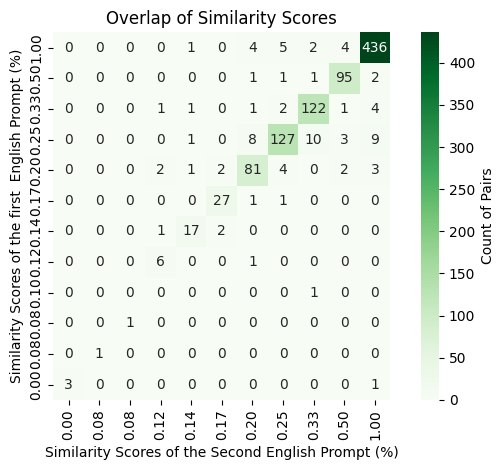

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset['triple_verbs'] = dataset['eng'] + ', ' + dataset['p1_transl'] + ', ' + dataset['eng_p1_transl']

# Add Index Column
#dataset["index"] = dataset["eng"] + "-" + dataset["translations_prompt1"]
dataset["index"] = dataset["triple_verbs"]

dataset.set_index("index", inplace=True)

# Create Pivot Table
piv = pd.pivot_table(dataset, values="triple_verbs", index=["similarity_eng_p1"], columns=["similarity_eng_p2"], aggfunc='count', fill_value=0)
print(piv)


# Format similarity scores to two decimal places
piv.index = piv.index.map(lambda x: f'{x:.2f}')
piv.columns = piv.columns.map(lambda x: f'{x:.2f}')


ax = sns.heatmap(piv, square=True, annot=True, fmt="d", cbar_kws={'label': 'Count of Pairs'}, cmap="Greens")
plt.xlabel('Similarity Scores of the Second English Prompt (%)')
plt.ylabel('Similarity Scores of the first  English Prompt (%)')
plt.title('Overlap of Similarity Scores')
plt.gca().invert_yaxis()  # Reverse y-axis
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()


similarity_p2  0.000000  0.076923  0.083333  0.125000  0.142857  0.166667  \
similarity_p1                                                               
0.000000              6         0         0         0         0         1   
0.076923              0         1         0         0         0         0   
0.083333              0         0         0         0         1         0   
0.090909              1         0         0         0         0         0   
0.111111              0         0         0         0         1         0   
0.125000              0         0         0         7         1         1   
0.142857              0         0         0         0        20         0   
0.166667              0         0         0         0         1        36   
0.200000              1         0         0         0         1         2   
0.250000              0         0         0         0         0         0   
0.333333              0         0         0         0         0         0   

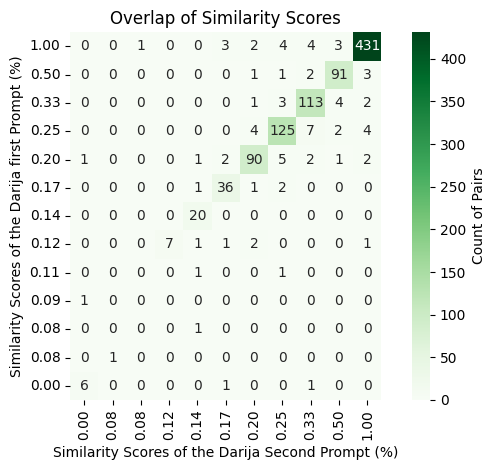

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset['triple_verbs'] = dataset['eng'] + ', ' + dataset['p1_transl'] + ', ' + dataset['p2_transl']

# Add Index Column
#dataset["index"] = dataset["eng"] + "-" + dataset["translations_prompt1"]
dataset["index"] = dataset["triple_verbs"]

dataset.set_index("index", inplace=True)

# Create Pivot Table
piv = pd.pivot_table(dataset, values="triple_verbs", index=["similarity_p1"], columns=["similarity_p2"], aggfunc='count', fill_value=0)
print(piv)


# Format similarity scores to two decimal places
piv.index = piv.index.map(lambda x: f'{x:.2f}')
piv.columns = piv.columns.map(lambda x: f'{x:.2f}')


ax = sns.heatmap(piv, square=True, annot=True, fmt="d", cbar_kws={'label': 'Count of Pairs'}, cmap="Greens")
plt.xlabel('Similarity Scores of the Darija Second Prompt (%)')
plt.ylabel('Similarity Scores of the Darija first Prompt (%)')
plt.title('Overlap of Similarity Scores')
plt.gca().invert_yaxis()  # Reverse y-axis
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()

In [12]:
print('filtered English prompt w 0 similarity')
filtered_p3 = [x for x in results_eng_p2 if x[2] < 0.13]
print(filtered_p3)

print('filtered Darija prompt w 0 similarity')
filtered = [x for x in results_p2 if x[2] < 0.13]
print(filtered)

print('filtered English prompt w 0 similarity')
filtered_p3 = [x for x in results_eng_p1 if x[2] < 0.13]
print(filtered_p3)

print('filtered Darija prompt w 0 similarity')
filtered = [x for x in results_p1 if x[2] < 0.13]
print(filtered)



filtered English prompt w 0 similarity
[('buy', 'bargain', 0.125, False), ('argue', 'marry', 0.125, False), ('sleep', 'intent', 0, False), ('be_honest', 'approve', 0, False), ('hurry', 'suspect', 0.125, False), ('shower', 'consult', 0.125, False), ('judge', 'sue', 0.07692307692307693, False), ('get_angry', 'swing', 0, False), ('strengthen', 'emphasize', 0.08333333333333333, False), ('massage', 'urge', 0.125, False), ('scare', 'deter', 0.125, False), ('mold', 'fool', 0.125, False), ('whisper', 'obscure', 0.125, False), ('return', 'revise', 0.125, False), ('grow', 'instruct', 0.125, False)]
filtered Darija prompt w 0 similarity
[('eat', 'bargain', 0.125, False), ('Thank_you', 'greet', 0, False), ('sleep', 'intent', 0, False), ('be_good', 'cook', 0, False), ('to_drink', 'translate', 0, False), ('to_drink', 'interpret', 0, False), ('shower', 'consult', 0.125, False), ('judge', 'sue', 0.07692307692307693, False), ('get_angry', 'swing', 0, False), ('scare', 'deter', 0.125, False), ('Thank_yo

In [13]:
import pandas as pd
data = pd.read_csv('verbs.csv')

duplicate_rows = data[data.duplicated(subset=['darija_ar', 'eng'], keep=False)]

# Extract the unique combinations of the duplicate rows
duplicate_combinations = duplicate_rows[['darija_ar', 'eng']].drop_duplicates()

print("Duplicate elements in columns 'A' and 'B':")
print(duplicate_combinations)

Duplicate elements in columns 'A' and 'B':
Empty DataFrame
Columns: [darija_ar, eng]
Index: []


In [19]:

filtered_pairs = dataset[(dataset['similarity_eng_p1']== 0) & (dataset['similarity_eng_p2'] == 0)]
print(filtered_pairs[['eng','p1_transl', 'p2_transl']])

                                 eng  p1_transl  p2_transl
index                                                     
intent, sleep, sleep          intent      sleep      sleep
approve, speak, believe      approve      speak    believe
swing, get angry, get angry    swing  get angry  get angry


In [14]:
#def p2_translate_(verb):
#    completion = client.chat.completions.create(
#        model="gpt-3.5-turbo",
#        messages = [
#            {"role": "system", "content": 
#                "نتا خبير فلهجة الدارجة المغربية وفالترجمة من الدارجة لنجليزية. " + 
#                "غادي نعطيك واحد الفعل بالدارجة المغربية، والمهمة ديالك هي تترجمو لفعل انجليزي واحد مجرد المصدر. " +
#                "الترجمة خص يكون فيها غير جذر الفعل المترجم بلا تفسيرات."            
#             },
#            {"role": "user", "content": "شرب"},
#            {"role": "assistant", "content": "drink"},
#            {"role": "user", "content":  f'{verb}' }
#        ],
#        temperature=0
#    )
#    return completion.choices[0].message.content
#def eng_p2_translate_(verb):
#    completion = client.chat.completions.create(
#        model="gpt-3.5-turbo",
#        messages = [
#            {"role": "system", "content": 
#             "You are an expert in Language translation from Moroccan Darija dialect to English. " +
#             "You will be provided with a verb in Moroccan Darija language, and your task is to translate it into ONE bare-infinitive English erb. " +
#             "The translation must contain only the lemma of the translated verb with no explanations."},
#            {"role": "user", "content": "شرب"},
#            {"role": "assistant", "content": "drink"},
#            {"role": "user", "content": f"{verb}"}
#        ],
#        temperature=0
#    )
#    return completion.choices[0].message.content

